# Imports

In [139]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from wordcloud import WordCloud
from src.utils import tratamento, extrair_hora, limpar_descricao
from src.criar_serie import criar_serie_contagem
from src.carga_dados import carregar_dados
from src.funcoes_eda import classificar_turno
from src.ajustes import padronizar_tipo_acidente, padronizar_tipo_evento
import sys
import os
print(os.getcwd())

print(sys.executable)

warnings.filterwarnings('ignore')

/Users/flavia.costa/Documents/projetos/previsao_acidentes_transito
/Users/flavia.costa/opt/anaconda3/bin/python


# Carga de dados

In [140]:
df = carregar_dados()

✅ Lido: csvs/acidentes-2019.csv
✅ Lido: csvs/acidentes_2020-novo.csv
✅ Lido: csvs/acidentes-transito-2015.csv
✅ Lido: csvs/acidentes_2016.csv
✅ Lido: csvs/acidentes_2017.csv
✅ Lido: csvs/acidentes_2018.csv
✅ Lido: csvs/acidentes2024.csv
✅ Lido: csvs/acidentes2021.csv
✅ Lido: csvs/acidentes2023.csv
✅ Lido: csvs/acidentes2022.csv

Total de arquivos lidos com sucesso: 10
Total de registros: 72255


# Processamento de dados

In [141]:
df.head()

,DATA,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,endereco_cruzamento,...,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,data,natureza,ï»¿data,Protocolo
0,2019-01-01,00:41:00,SEM VÃTIMA,FINALIZADA,IPSEP,AV RECIFE,NaN,NaN,LADO OPOSTO AO NÂº 3257,AV RECIFE,...,NÃ£o hÃ¡ placas,60 km/h,Ãnica,Faixa seccionada,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,01:37:00,SEM VÃTIMA,FINALIZADA,BOA VIAGEM,RUA PADRE BERNADINO PESSOA,NaN,RUA MINISTRO NELSON HUNGRIA,NaN,RUA PADRE BERNADINO PESSOA,...,NÃ£o hÃ¡ placas,NaN,Ãnica,NÃ£o existe,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,14:20:00,SEM VÃTIMA,CANCELADA,BOA VIAGEM,AV ENGENHEIRO DOMINGOS FERREIRA,NaN,RUA DOM JOSE LOPES,"EM FRENTE A DELEGACIA DE BOA VIAGEM, LADO ESQU...",AV ENGENHEIRO DOMINGOS FERREIRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,02:53:00,SEM VÃTIMA,CANCELADA,IMBIRIBEIRA,AV GENERAL MAC ARTHUR,100,RUA JACY,EM FRENTE A ART LED ILUMINAÃÃO,AV GENERAL MAC ARTHUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,08:17:00,COM VÃTIMA,FINALIZADA,JAQUEIRA,RUA TITO ROSAS,63,NaN,ED. JARDINS DA JAQUEIRA,RUA TITO ROSAS,...,NÃ£o hÃ¡ placas,40 km/h,Ãnica,Faixa seccionada,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
# Tratar horário
df['hora_limpa'] = df['hora'].apply(extrair_hora)
print(df['hora_limpa'].unique())


[ 0.  1. 14.  2.  8.  9. 13. 15. 16. 17. 19. 20. 21.  6.  7. 11. 12. 18.
 23. 10. 22.  4.  5.  3. nan 48. 29.]


In [143]:
# Tratar descrição para nuvem de palavras
#df['descricao_limpa'] = df['descricao'].dropna().apply(limpar_descricao)


In [144]:
print(df.columns)

Index(['DATA', 'hora', 'natureza_acidente', 'situacao', 'bairro', 'endereco',
       'numero', 'detalhe_endereco_acidente', 'complemento',
       'endereco_cruzamento', 'numero_cruzamento', 'referencia_cruzamento',
       'bairro_cruzamento', 'num_semaforo', 'sentido_via', 'tipo', 'descricao',
       'auto', 'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao',
       'viatura', 'outros', 'vitimas', 'vitimasfatais', 'acidente_verificado',
       'tempo_clima', 'situacao_semaforo', 'sinalizacao', 'condicao_via',
       'conservacao_via', 'ponto_controle', 'situacao_placa',
       'velocidade_max_via', 'mao_direcao', 'divisao_via1', 'divisao_via2',
       'divisao_via3', 'data', 'natureza', 'ï»¿data', 'Protocolo',
       'hora_limpa'],
      dtype='object')


In [145]:
df.rename(columns={'ï»¿data': 'i_data'}, inplace=True)

Tratamento de datas nulas em colunas distintas - Unificação

In [146]:
def parse_date_column(col):
    # Tenta com dayfirst=True
    dt = pd.to_datetime(df[col], errors='coerce', dayfirst=True)
    # Onde deu NaT, tenta com dayfirst=False
    mask = dt.isna() & df[col].notna()
    dt.loc[mask] = pd.to_datetime(df.loc[mask, col], errors='coerce', dayfirst=False)
    return dt

# Faz o parse das 3 colunas
df['data_dt'] = parse_date_column('data')
df['DATA_dt'] = parse_date_column('DATA')
df['i_data_dt'] = parse_date_column('i_data')

# Agora, unifica: prioridade para data_dt, se nulo tenta DATA_dt, se nulo tenta i_data_dt
df['data_unificada'] = df['data_dt']
mask = df['data_unificada'].isna()
df.loc[mask, 'data_unificada'] = df.loc[mask, 'DATA_dt']
mask = df['data_unificada'].isna()
df.loc[mask, 'data_unificada'] = df.loc[mask, 'i_data_dt']

print("Valores válidos em data_unificada:", df['data_unificada'].notna().sum())

Valores válidos em data_unificada: 72255


In [147]:
tratamento(df)
df.head(10)

,DATA,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,endereco_cruzamento,...,divisao_via3,data,natureza,i_data,Protocolo,hora_limpa,data_dt,DATA_dt,i_data_dt,data_unificada
0,2019-01-01,00:41:00,SEM VATIMA,FINALIZADA,IPSEP,AV RECIFE,NaN,NaN,LADO OPOSTO AO NAo 3257,AV RECIFE,...,NaN,NaN,NaN,NaN,NaN,0.0,NaT,2019-01-01,NaT,2019-01-01
1,2019-01-01,01:37:00,SEM VATIMA,FINALIZADA,BOA VIAGEM,RUA PADRE BERNADINO PESSOA,NaN,RUA MINISTRO NELSON HUNGRIA,NaN,RUA PADRE BERNADINO PESSOA,...,NaN,NaN,NaN,NaN,NaN,1.0,NaT,2019-01-01,NaT,2019-01-01
2,2019-01-01,14:20:00,SEM VATIMA,CANCELADA,BOA VIAGEM,AV ENGENHEIRO DOMINGOS FERREIRA,NaN,RUA DOM JOSE LOPES,"EM FRENTE A DELEGACIA DE BOA VIAGEM, LADO ESQU...",AV ENGENHEIRO DOMINGOS FERREIRA,...,NaN,NaN,NaN,NaN,NaN,14.0,NaT,2019-01-01,NaT,2019-01-01
3,2019-01-01,02:53:00,SEM VATIMA,CANCELADA,IMBIRIBEIRA,AV GENERAL MAC ARTHUR,100,RUA JACY,EM FRENTE A ART LED ILUMINAAAO,AV GENERAL MAC ARTHUR,...,NaN,NaN,NaN,NaN,NaN,2.0,NaT,2019-01-01,NaT,2019-01-01
4,2019-01-01,08:17:00,COM VATIMA,FINALIZADA,JAQUEIRA,RUA TITO ROSAS,63,NaN,ED. JARDINS DA JAQUEIRA,RUA TITO ROSAS,...,NaN,NaN,NaN,NaN,NaN,8.0,NaT,2019-01-01,NaT,2019-01-01
5,2019-01-01,09:30:00,COM VATIMA,FINALIZADA,IBURA,AV DOIS RIOS,1392,NaN,IBURA DE BAIXO EM FRENTE A IGREJA PAZ E VIDA,AV DOIS RIOS,...,NaN,NaN,NaN,NaN,NaN,9.0,NaT,2019-01-01,NaT,2019-01-01
6,2019-01-01,09:54:00,COM VATIMA,FINALIZADA,SAN MARTIN,AV GENERAL SAN MARTIN,1622,NaN,APAS AO BATLHAO DE CAVALARIA DA PMPE,AV GENERAL SAN MARTIN,...,NaN,NaN,NaN,NaN,NaN,9.0,NaT,2019-01-01,NaT,2019-01-01
7,2019-01-01,13:05:00,SEM VATIMA,FINALIZADA,BONGI,EST DO BONGI,290,NaN,EM FRENTE A OFICINA DA FIORI,EST DO BONGI,...,NaN,NaN,NaN,NaN,NaN,13.0,NaT,2019-01-01,NaT,2019-01-01
8,2019-01-01,15:50:00,SEM VATIMA,FINALIZADA,MADALENA,EST DOS REMEDIOS,2360,NaN,E/F A PB AUTOMOVEIS MULTIMARCAS,EST DOS REMEDIOS,...,NaN,NaN,NaN,NaN,NaN,15.0,NaT,2019-01-01,NaT,2019-01-01
9,2019-01-01,16:01:00,COM VATIMA,CANCELADA,CAMPO GRANDE,EST DE BELEM,NaN,NaN,E/F A IGREJA UNIVERSAL NO ANTIGO TERMINAL DE C...,EST DE BELEM,...,NaN,NaN,NaN,NaN,NaN,16.0,NaT,2019-01-01,NaT,2019-01-01


In [148]:
df.shape

(72255, 50)

In [149]:
df['ano'] = df['data_unificada'].dt.year.astype('Int64')  
df['mes'] = df['data_unificada'].dt.month.astype('Int64')
df['dia_semana'] = df['data_unificada'].dt.dayofweek.astype('Int64')



In [150]:
df['ano'].unique()

<IntegerArray>
[2019, 2020, 2015, 2016, 2017, 2018, 2024, 2025, 2021, 2023, 2022]
Length: 11, dtype: Int64

In [151]:
print(df['bairro'].isnull().sum())
print(df['bairro'].value_counts().head(10))


360
BOA VIAGEM      8960
IMBIRIBEIRA     4330
SANTO AMARO     3516
AFOGADOS        2744
BOA VISTA       2640
MADALENA        2638
DERBY           2006
CASA AMARELA    1992
IPSEP           1922
PINA            1897
Name: bairro, dtype: int64


In [152]:
df['vitimas'] = pd.to_numeric(df['vitimas'], errors='coerce')
df['vitimasfatais'] = pd.to_numeric(df['vitimasfatais'], errors='coerce')
df['auto'] = pd.to_numeric(df['auto'], errors='coerce')
df['moto'] = pd.to_numeric(df['moto'], errors='coerce')
df['ciclom'] = pd.to_numeric(df['ciclom'], errors='coerce')
df['ciclista'] = pd.to_numeric(df['ciclista'], errors='coerce')
df['pedestre'] = pd.to_numeric(df['pedestre'], errors='coerce')
df['onibus'] = pd.to_numeric(df['onibus'], errors='coerce')
df['caminhao'] = pd.to_numeric(df['caminhao'], errors='coerce')
df['viatura'] = pd.to_numeric(df['viatura'], errors='coerce')
df['outros'] = pd.to_numeric(df['outros'], errors='coerce')

Categorias

In [153]:
tipo_veiculos = [
    'auto', 
    'moto', 
    'ciclom', 
    'ciclista', 
    'pedestre', 
    'onibus', 
    'caminhao',
    'viatura', 
    'outros'
]
soma_veiculos = df[tipo_veiculos].sum().astype(int)
print(soma_veiculos.sort_values(ascending=False))


auto        84411
moto        17183
onibus       9315
caminhao     5996
pedestre     1469
ciclista     1011
viatura       803
outros        716
ciclom        424
dtype: int64


Tipo de vitima

In [154]:
tipo_vitima = [
    'vitimas', 
    'vitimasfatais'
]
soma_vitimas = df[tipo_vitima].sum().astype(int).sort_index(ascending=False)
print(soma_vitimas.sort_values(ascending=False))

vitimas          16004
vitimasfatais      175
dtype: int64


Classificação de turno

In [155]:
df['turno'] = df['hora_limpa'].apply(classificar_turno)

In [156]:
df = padronizar_tipo_evento(df, coluna='tipo')
df = padronizar_tipo_acidente(df, coluna='natureza_acidente')


In [157]:
# Define a ordem correta dos dias e turnos
ordem_dias = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
ordem_turnos = ['Madrugada', 'Manhã', 'Tarde', 'Noite', 'Indefinido']

# Mapeia os dias
df['dia_nome'] = df['dia_semana'].map(dict(enumerate(ordem_dias)))

# Converte para categorias ordenadas
df['dia_nome'] = pd.Categorical(df['dia_nome'], categories=ordem_dias, ordered=True)
df['turno'] = pd.Categorical(df['turno'], categories=ordem_turnos, ordered=True)



Gráficos exploratórios

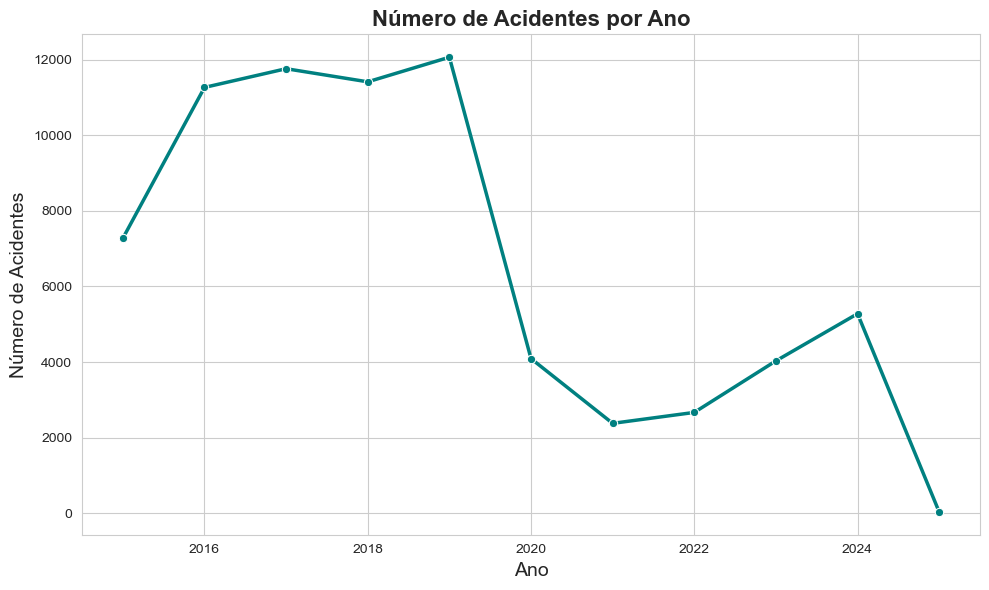

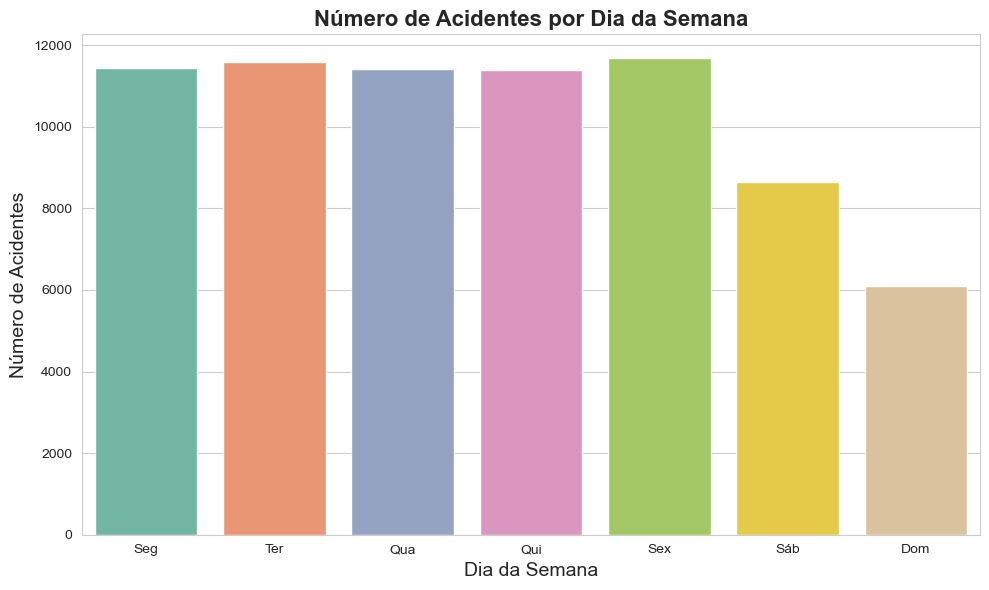

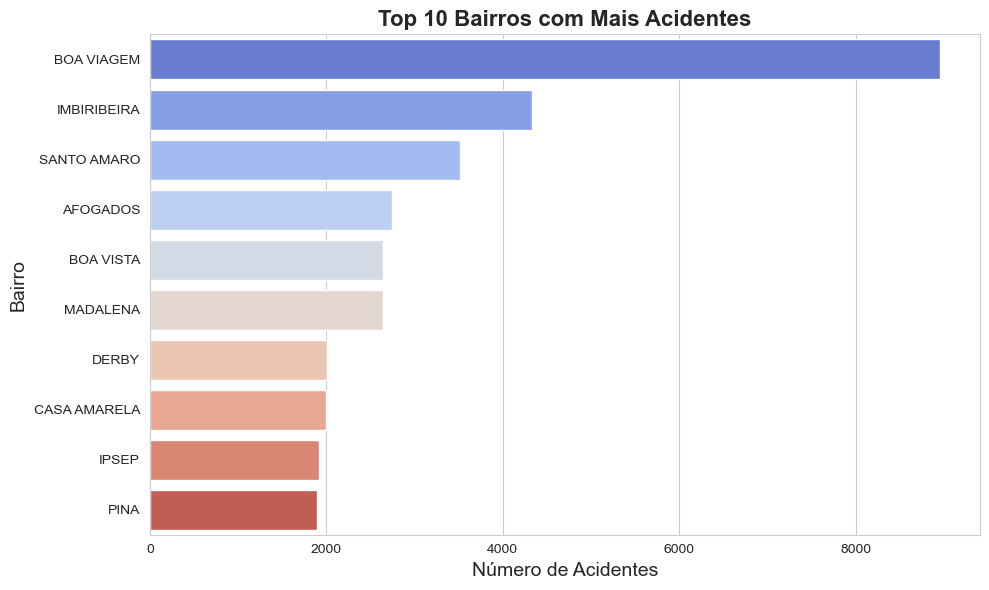

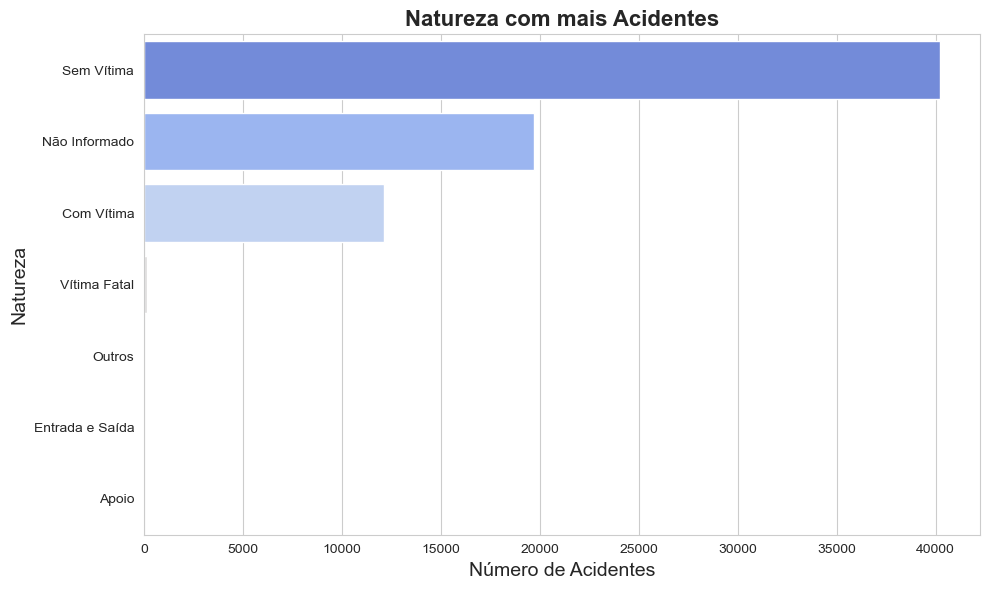

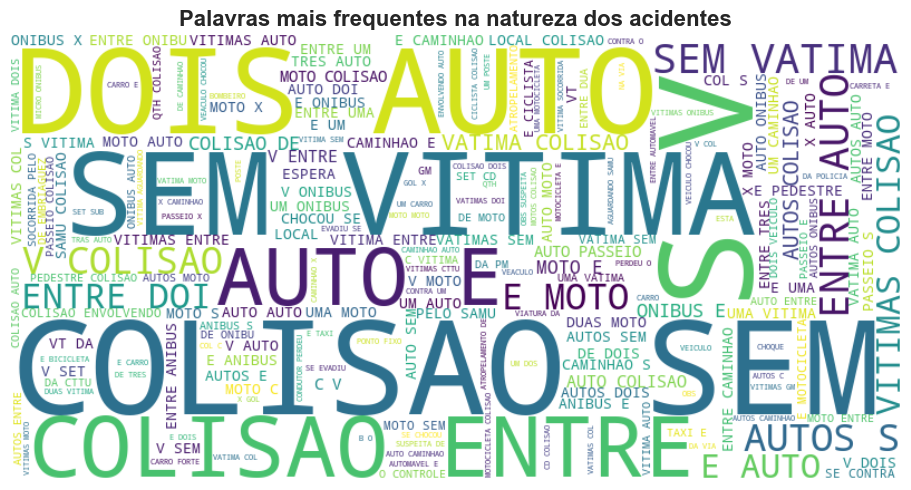

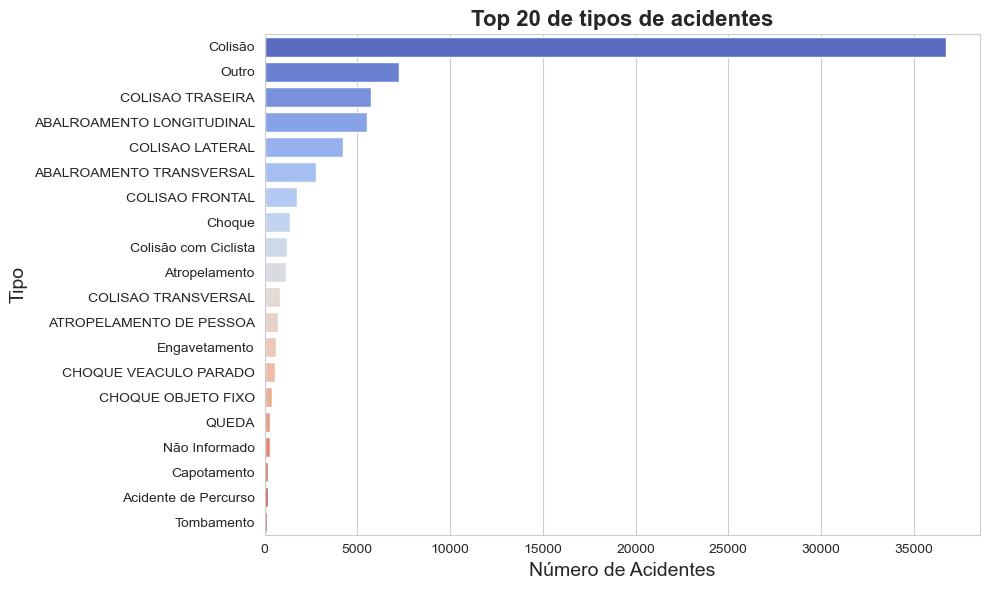

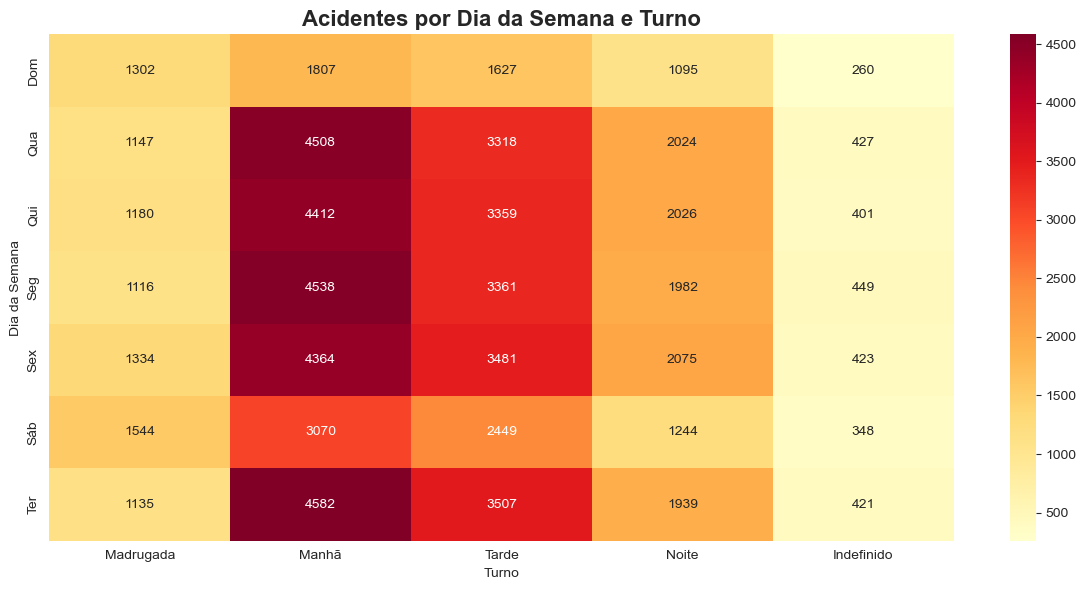

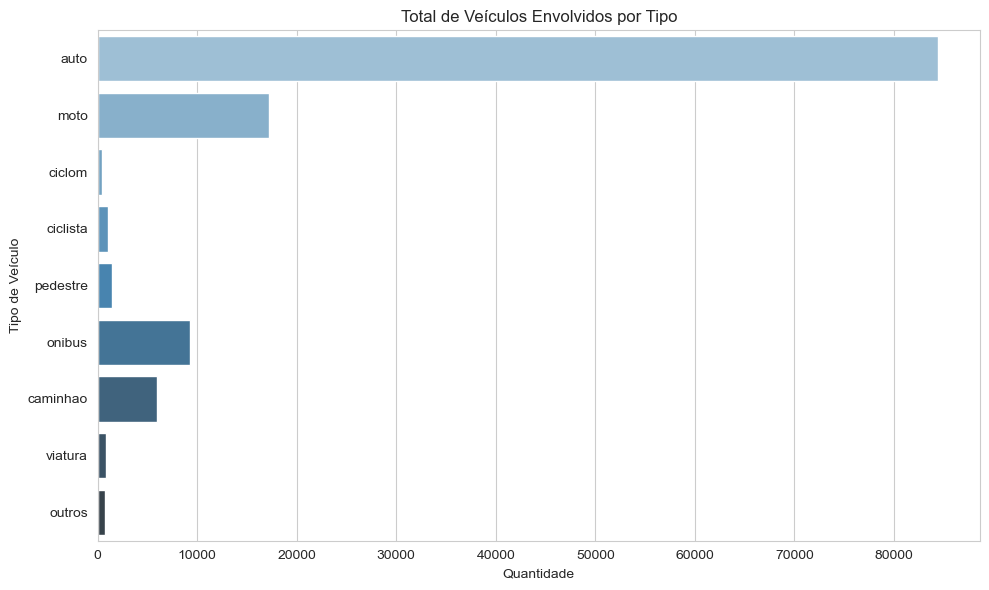

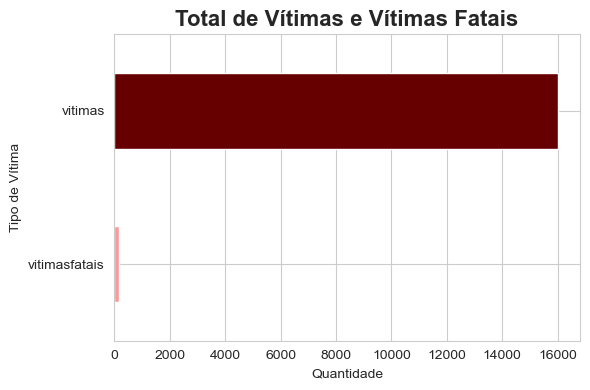

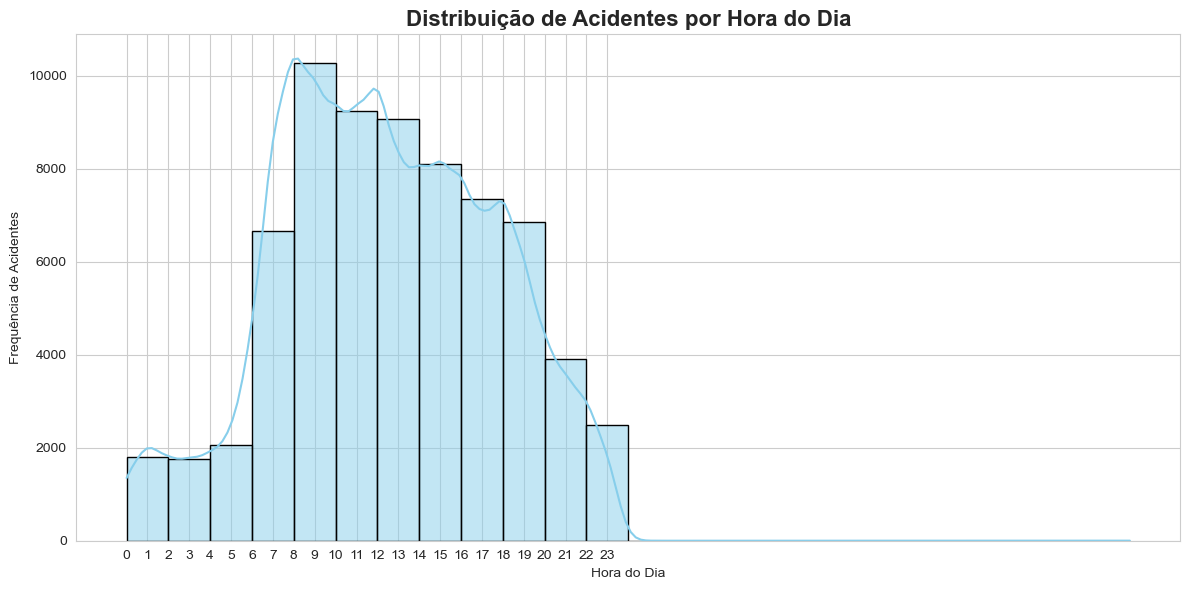

In [158]:
# 3. Visualizações iniciais

# Acidentes por ano
sns.set_style('whitegrid')
palette = sns.color_palette('pastel')

# 1. Acidentes por ano
acidentes_ano = df['ano'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=acidentes_ano.index, y=acidentes_ano.values, marker='o', linewidth=2.5, color='teal')
plt.title('Número de Acidentes por Ano', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Número de Acidentes', fontsize=14)
plt.tight_layout()
plt.show()


# 2. Acidentes por dia da semana
df['dia_nome'] = df['dia_semana'].map(dict(enumerate(ordem_dias)))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dia_nome', order=ordem_dias, palette='Set2')
plt.title('Número de Acidentes por Dia da Semana', fontsize=16, weight='bold')
plt.xlabel('Dia da Semana', fontsize=14)
plt.ylabel('Número de Acidentes', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Top 10 bairros com mais acidentes
top_bairros = df['bairro'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_bairros.values, y=top_bairros.index, palette='coolwarm')
plt.title('Top 10 Bairros com Mais Acidentes', fontsize=16, weight='bold')
plt.xlabel('Número de Acidentes', fontsize=14)
plt.ylabel('Bairro', fontsize=14)
plt.tight_layout()
plt.show()

# 4. Natureza com mais acidentes
top_natureza = df['natureza_acidente'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_natureza.values, y=top_natureza.index, palette='coolwarm')
plt.title('Natureza com mais Acidentes', fontsize=16, weight='bold')
plt.xlabel('Número de Acidentes', fontsize=14)
plt.ylabel('Natureza', fontsize=14)
plt.tight_layout()
plt.show()

texto = ' '.join(df['descricao'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texto)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes na natureza dos acidentes', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# 5. Top 20 tipo com mais acidentes
tipo = df['tipo'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=tipo.values, y=tipo.index, palette='coolwarm')
plt.title('Top 20 de tipos de acidentes', fontsize=16, weight='bold')
plt.xlabel('Número de Acidentes', fontsize=14)
plt.ylabel('Tipo', fontsize=14)
plt.tight_layout()
plt.show()

# 6. Acidentes por turno

turno = df['turno'].value_counts()
tabela = pd.crosstab(df['dia_nome'], df['turno'])
plt.figure(figsize=(12, 6))
sns.heatmap(tabela, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Acidentes por Dia da Semana e Turno', fontsize=16, weight='bold')
plt.xlabel('Turno')
plt.ylabel('Dia da Semana')
plt.tight_layout()
plt.show()

# 7. Acidentes por tipo de veiculo

plt.figure(figsize=(10, 6))
sns.barplot(x=soma_veiculos.values, y=soma_veiculos.index, palette='Blues_d')
plt.title('Total de Veículos Envolvidos por Tipo')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Veículo')
plt.tight_layout()
plt.show()

# 7. Acidentes - vitimas e vitimas fatais
plt.figure(figsize=(6, 4))
soma_vitimas.plot(kind='barh', color=['#ff9999', '#660000'])
plt.title('Total de Vítimas e Vítimas Fatais', fontsize=16, weight='bold')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Vítima')
plt.tight_layout()
plt.show()

# 8. Acidentes por hora do dia
plt.figure(figsize=(12, 6))
sns.histplot(df['hora_limpa'], bins=24, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribuição de Acidentes por Hora do Dia', fontsize=16, weight='bold')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência de Acidentes')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()




Analise de registros sem data

In [159]:
# Total de registros
total = len(df)

# Total de registros sem data
total_sem_data = df['data_unificada'].isnull().sum()

# Total de registros com data
total_com_data = total - total_sem_data

# Proporção de registros sem data
proporcao_sem_data = (total_sem_data / total) * 100

# Proporção de registros com data
proporcao_com_data = (total_com_data / total) * 100

# Mostra o resultado
print(f"Total de registros: {total}")
print(f"Com data: {total_com_data} ({proporcao_com_data:.2f}%)")
print(f"Sem data: {total_sem_data} ({proporcao_sem_data:.2f}%)")


Total de registros: 72255
Com data: 72255 (100.00%)
Sem data: 0 (0.00%)


# Série temporal

Criar série com limite de data final

In [160]:
data_final_serie = '2024-12-31'

df_com_data = df[df['data_unificada'].notnull()].copy()

df_com_data['data_unificada'] = pd.to_datetime(df_com_data['data_unificada'])

serie = df_com_data.groupby('data_unificada').size()
serie = serie.asfreq('D')  # define frequência diária
serie = serie.loc[:data_final_serie]

dias_sem_acidente = serie[serie.isnull()].index

print("Número de dias sem acidentes:", len(dias_sem_acidente))
print("Exemplos de dias sem acidentes:", dias_sem_acidente[:50])


Número de dias sem acidentes: 24
Exemplos de dias sem acidentes: DatetimeIndex(['2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-28', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
               '2020-04-12', '2020-04-13', '2020-10-26', '2021-03-11',
               '2021-06-20', '2022-02-05', '2022-02-27', '2022-05-28',
               '2022-05-29', '2024-12-29', '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='data_unificada', freq=None)


Série com data inicial definida

In [161]:
serie_data = serie[serie.index >= '2021-01-01']
# 4. Obter os dias sem acidentes (valores nulos)
dias_sem_acidente = serie_data[serie_data.isnull()].index

# Exibir resultado
print("Número de dias sem acidentes:", len(dias_sem_acidente))
print("Exemplos de dias sem acidentes:", dias_sem_acidente[:10])

Número de dias sem acidentes: 9
Exemplos de dias sem acidentes: DatetimeIndex(['2021-03-11', '2021-06-20', '2022-02-05', '2022-02-27',
               '2022-05-28', '2022-05-29', '2024-12-29', '2024-12-30',
               '2024-12-31'],
              dtype='datetime64[ns]', name='data_unificada', freq=None)


<AxesSubplot:xlabel='data_unificada'>

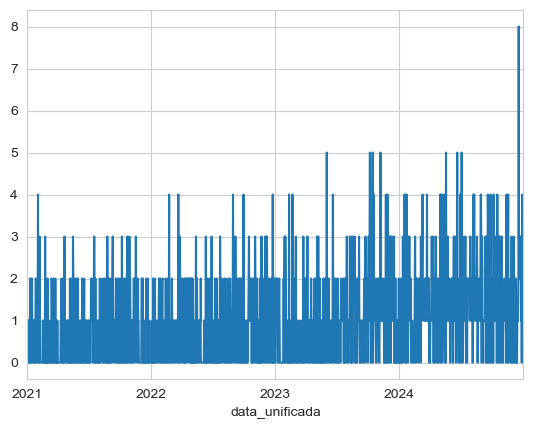

In [162]:
# 3. Criar a série temporal por dia e bairro
serie_bairro = (
    df_com_data
    .groupby(['data_unificada', 'bairro'])
    .size()
    .unstack(fill_value=0)
)

serie_bairro = serie_bairro.asfreq('D') 
serie_bairro = serie_bairro.loc[:data_final_serie] 

serie_bairro = serie_bairro[serie_bairro.index >= '2021-01-01']
serie_bairro['BOA VIAGEM'].plot()


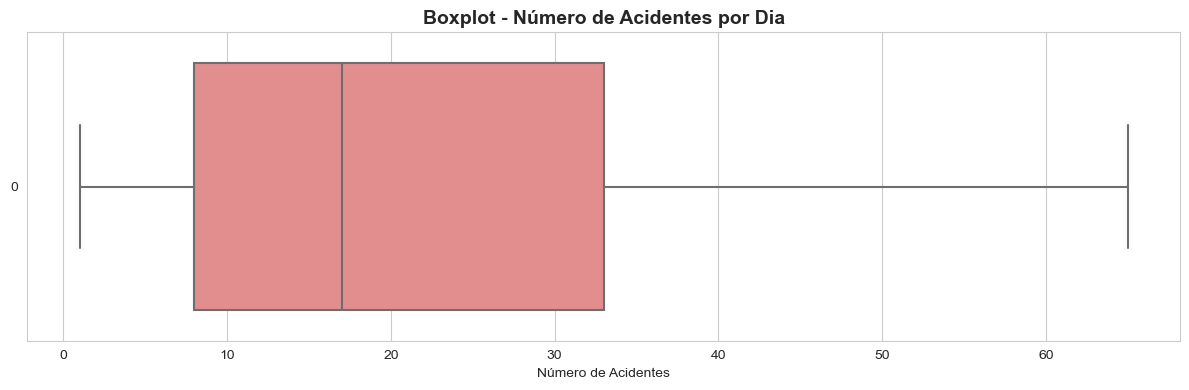

In [163]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=serie, orient='h', color='lightcoral')
plt.title("Boxplot - Número de Acidentes por Dia", fontsize=14, weight='bold')
plt.xlabel("Número de Acidentes")
plt.tight_layout()
plt.show()


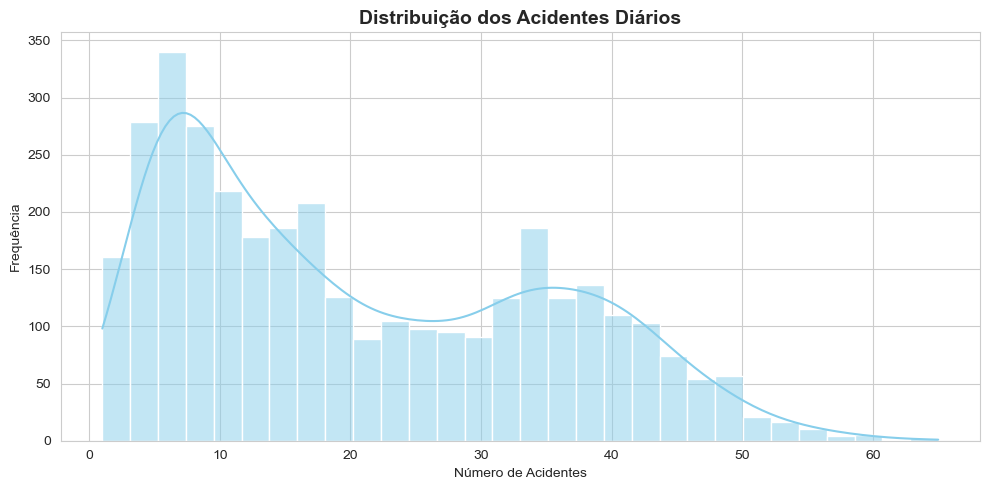

In [164]:
plt.figure(figsize=(10, 5))
sns.histplot(serie, bins=30, kde=True, color='skyblue')
plt.title("Distribuição dos Acidentes Diários", fontsize=14, weight='bold')
plt.xlabel("Número de Acidentes")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


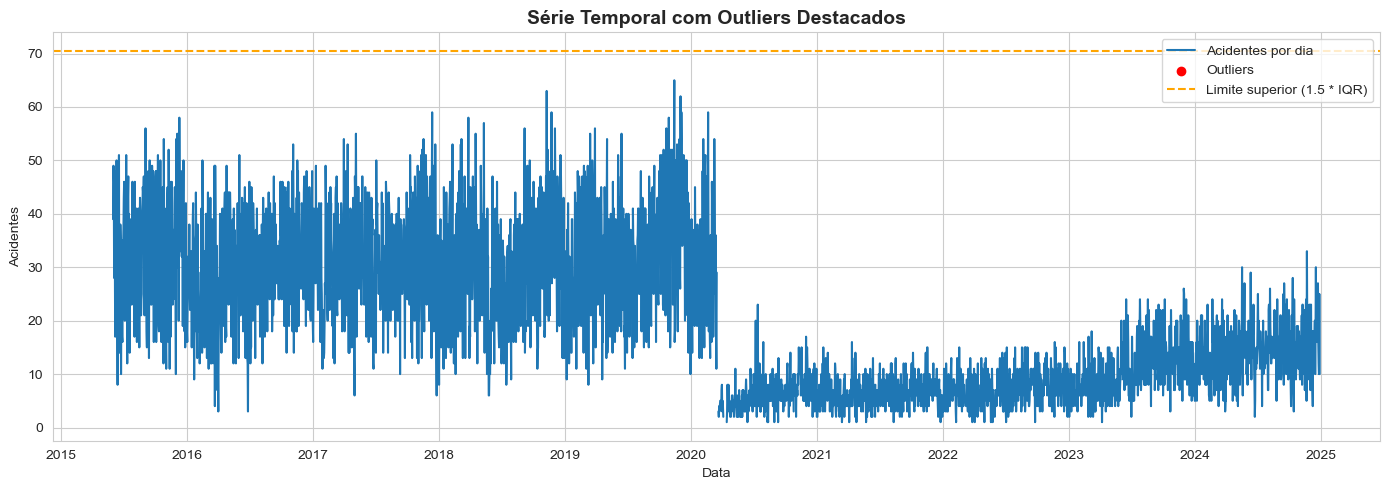

In [165]:
Q1 = serie.quantile(0.25)
Q3 = serie.quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR

outliers = serie[serie > limite_superior]

plt.figure(figsize=(14, 5))
plt.plot(serie, label='Acidentes por dia')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.axhline(limite_superior, color='orange', linestyle='--', label='Limite superior (1.5 * IQR)')
plt.title('Série Temporal com Outliers Destacados', fontsize=14, weight='bold')
plt.xlabel('Data')
plt.ylabel('Acidentes')
plt.legend()
plt.tight_layout()
plt.show()


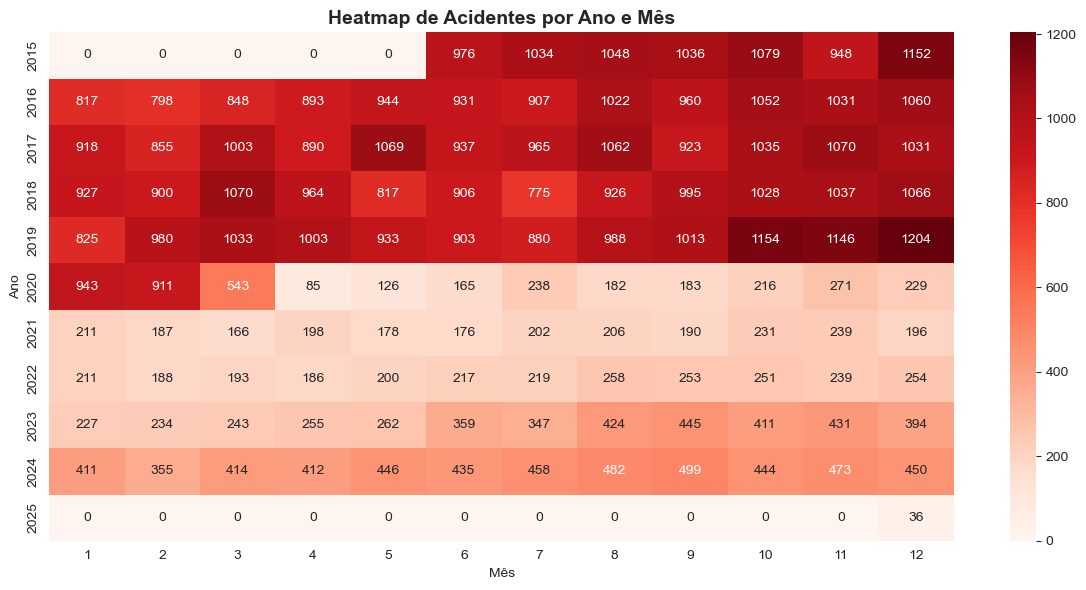

In [166]:
df_com_data['ano'] = df_com_data['data_unificada'].dt.year
df_com_data['mes'] = df_com_data['data_unificada'].dt.month

tabela = df_com_data.groupby(['ano', 'mes']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(tabela, annot=True, fmt='d', cmap='Reds')
plt.title("Heatmap de Acidentes por Ano e Mês", fontsize=14, weight='bold')
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.tight_layout()
plt.show()


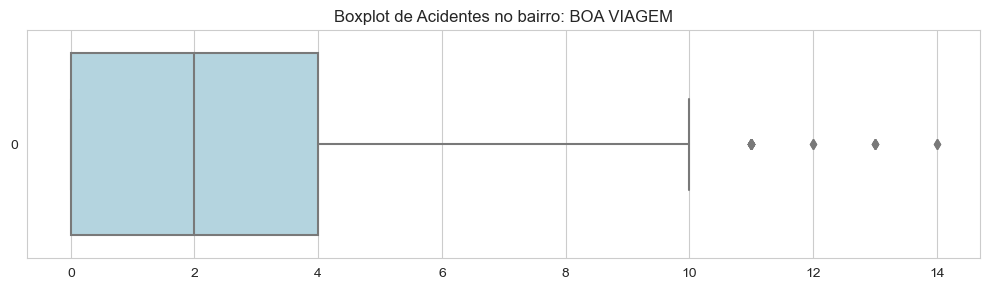

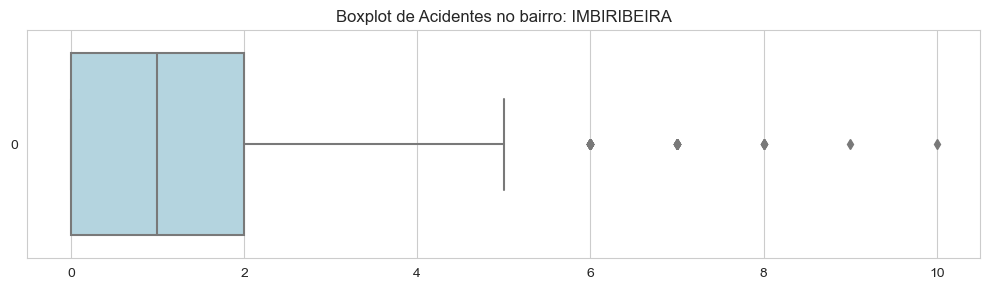

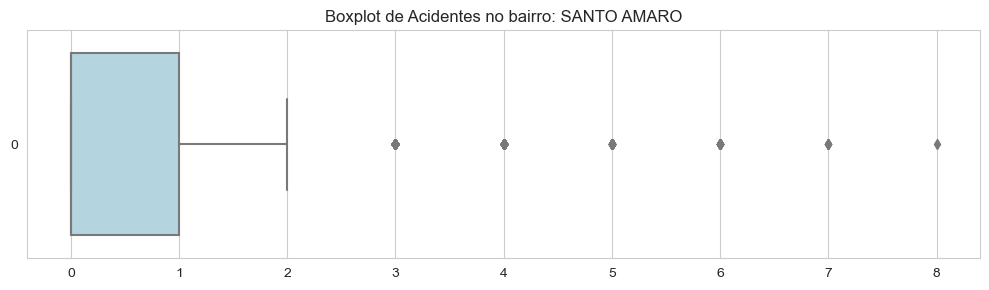

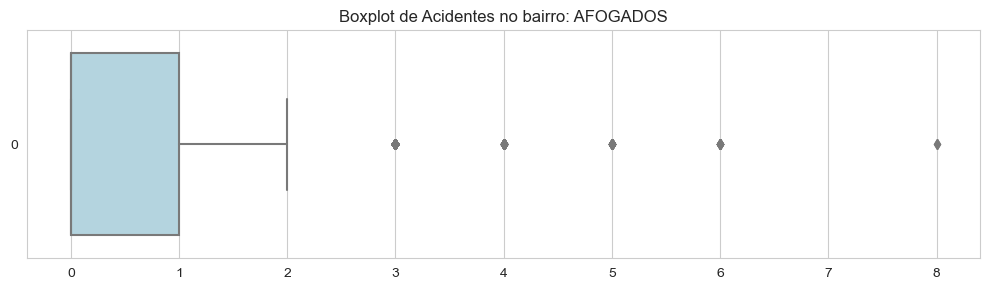

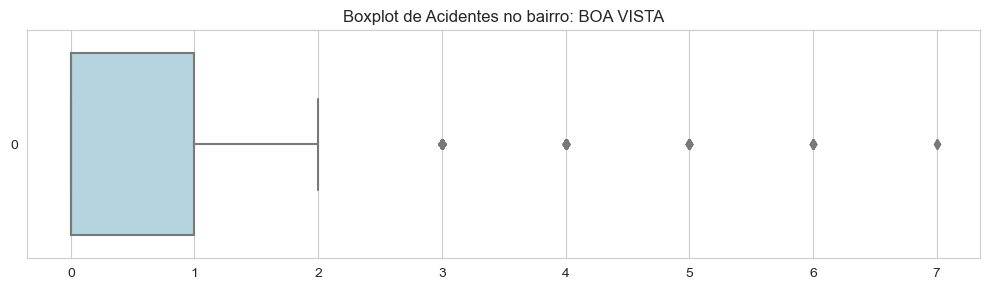

In [167]:
top_bairros = df['bairro'].value_counts().head(5).index

for bairro in top_bairros:
    serie_bairro = (
        df[(df['bairro'] == bairro) & (df['data_unificada'].notna())]
        .groupby('data_unificada')
        .size()
        .asfreq('D')
        .fillna(0)
    )
    
    plt.figure(figsize=(10, 3))
    sns.boxplot(data=serie_bairro, orient='h', color='lightblue')
    plt.title(f"Boxplot de Acidentes no bairro: {bairro}")
    plt.tight_layout()
    plt.show()


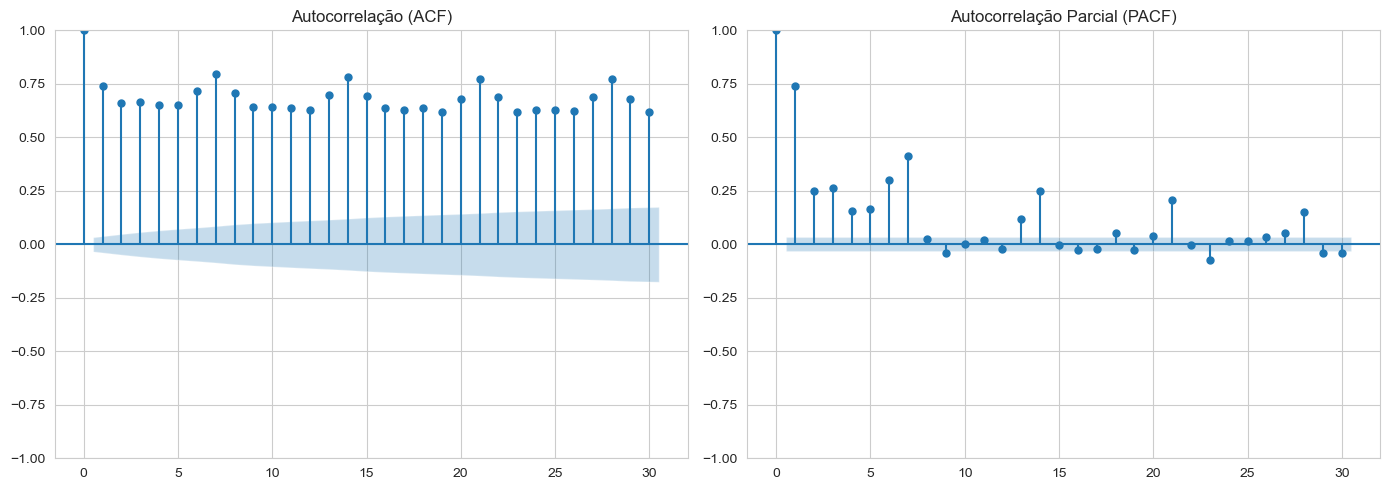

In [168]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(serie.dropna(), lags=30, ax=plt.gca())
plt.title("Autocorrelação (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(serie.dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title("Autocorrelação Parcial (PACF)")

plt.tight_layout()
plt.show()


🔎 Decomposição com período = 7


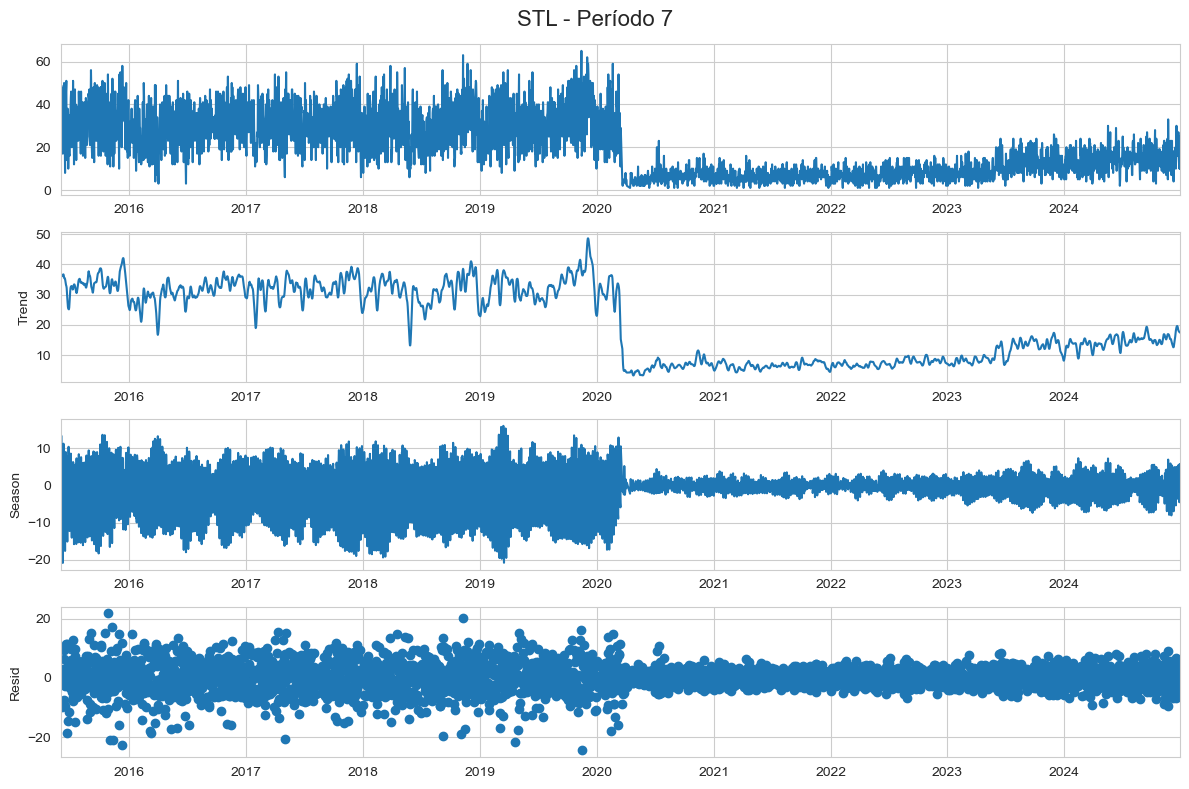


🔎 Decomposição com período = 30


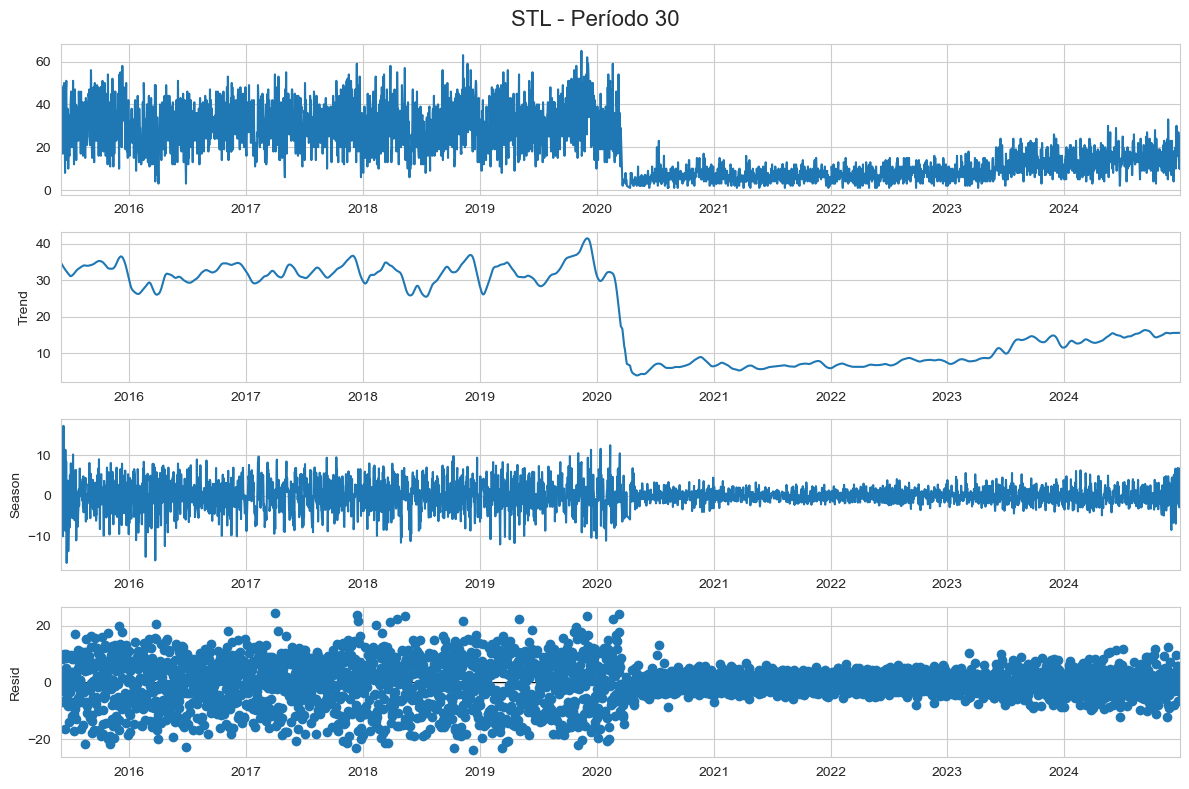


🔎 Decomposição com período = 365


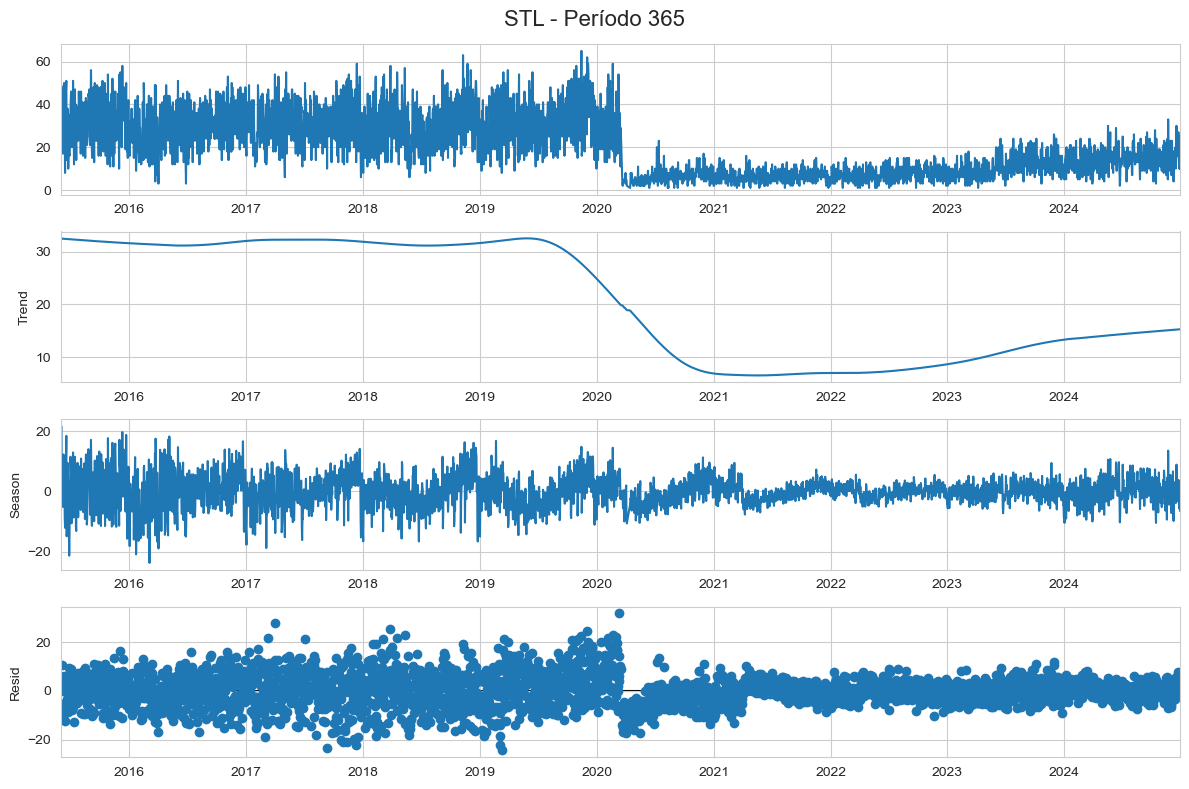

In [169]:
for p in [7, 30, 365]:
    print(f'\n🔎 Decomposição com período = {p}')
    
    stl = STL(serie.dropna(), period=p)
    resultado = stl.fit()
    
    fig = resultado.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"STL - Período {p}", fontsize=16)
    plt.tight_layout()
    plt.show()




In [170]:
print(serie.index.min(), serie.index.max())


2015-06-01 00:00:00 2024-12-31 00:00:00


In [171]:
resultado = adfuller(serie.dropna())

print("Estatística ADF:", resultado[0])
print("p-valor:", resultado[1])
print("Valores Críticos:")
for chave, valor in resultado[4].items():
    print(f"   {chave}: {valor}")

if resultado[1] < 0.05:
    print("✅ A série é estacionária (rejeita H0)")
else:
    print("❌ A série NÃO é estacionária (não rejeita H0)")

Estatística ADF: -1.8818351937985627
p-valor: 0.3406540626586123
Valores Críticos:
   1%: -3.4322479625901536
   5%: -2.8623786111734746
   10%: -2.567216407968438
❌ A série NÃO é estacionária (não rejeita H0)


In [172]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # evita divisão por zero
    return np.mean(diff) * 100


Modelagem acima de 2020

In [173]:
serie = serie[serie.index >= '2021-01-01']

# Arima

In [34]:
from src.dividir_modelagem import dividir_modelagem, dividir_modelagem_2
from src.modelo_arima import modelar_arima_automatico

# 3. Cria a série temporal diária
#serie = (
    #df_com_data
    #.groupby('data_unificada')
    #.size()
#)

full_index = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq='D')
serie = serie.reindex(full_index).fillna(0)

# 4. Divide em treino, validação e teste
y_train, y_test = dividir_modelagem_2(serie)

# 5. Modela com ARIMA automático
resultados_auto = modelar_arima_automatico(y_train,  y_test)

# 6. Mostra os resultados
print(f"\nOrdem final encontrada: {resultados_auto['melhor_ordem']}")
#print(f"MAE Validação: {resultados_auto['mae_val']:.2f}")
print(f"MAE Teste: {resultados_auto['mae_test']:.2f}")

Tamanho Treino: 1022, Teste: 439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5459.093, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6082.168, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5810.637, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5454.119, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6080.170, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5455.115, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5455.122, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5456.081, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5454.248, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.796 seconds

Ordem final encontrada: (0, 1, 1)
MAE Teste: 4.36


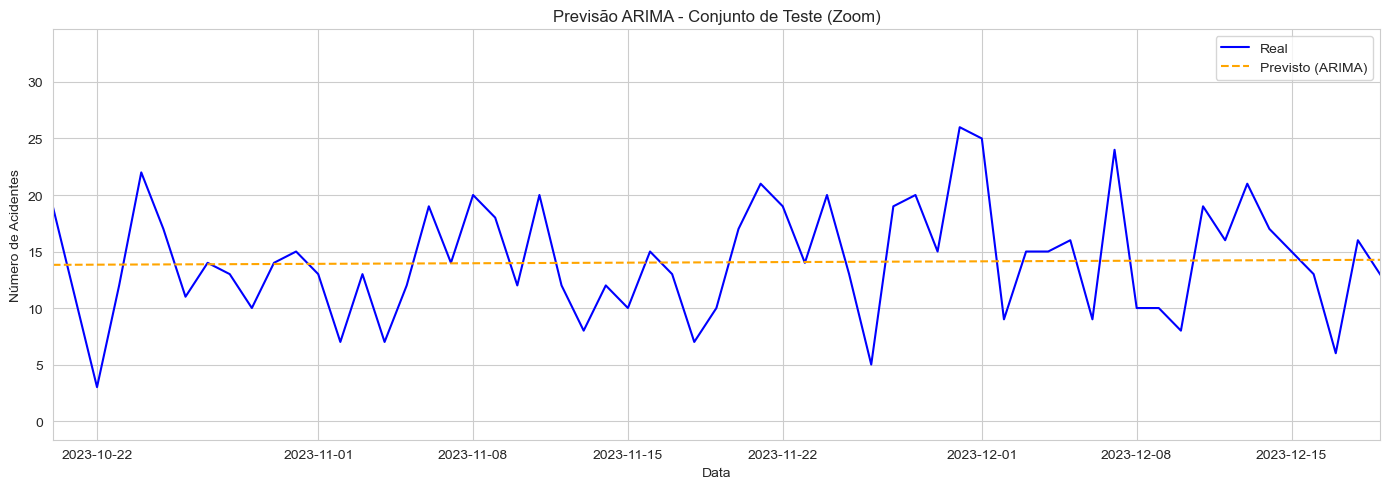

In [35]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Real', color='blue')
plt.plot(y_test.index, resultados_auto['previsao_test'], label='Previsto (ARIMA)', color='orange', linestyle='--')
plt.title('Previsão ARIMA - Conjunto de Teste (Zoom)')
plt.xlabel('Data')
plt.ylabel('Número de Acidentes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(y_test.index.min(), y_test.index.min() + pd.Timedelta(days=60))
plt.show()



In [36]:
# Obtém o modelo ARIMA treinado
modelo = resultados_auto['modelo']

# Previsão para o próximo dia
previsao_proximo_dia = modelo.predict(n_periods=1)[0]

# Exibir o valor previsto
print(f"Previsão de acidentes para o próximo dia: {previsao_proximo_dia:.2f}")


Previsão de acidentes para o próximo dia: 13.82


Tamanho Treino: 876, Validação: 292, Teste: 293
Teste ADF em y_train:
ADF Statistic: -3.9131
p-valor: 0.0019
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=-554.915, Time=10.09 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=30.533, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-226.499, Time=1.68 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-561.661, Time=3.98 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=28.537, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=-561.454, Time=4.97 sec
 ARIMA(0,1,1)(0,0,2)[30] intercept   : AIC=-561.432, Time=24.33 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=-562.067, Time=4.09 sec
 ARIMA(0,1,1)(2,0,0)[30] intercept   : AIC=-561.679, Time=28.87 sec
 ARIMA(0,1,1)(2,0,1)[30] intercept   : AIC=-559.965, Time=25.29 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=26.250, Time=0.79 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=-560.067

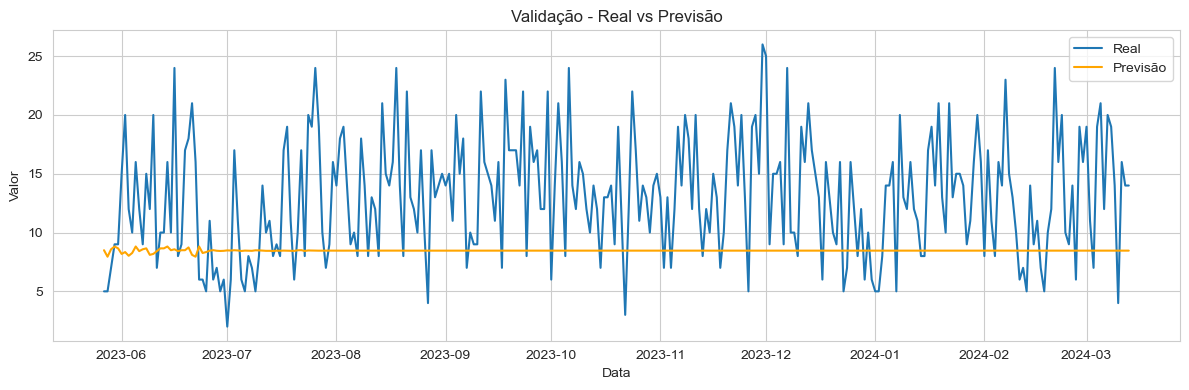

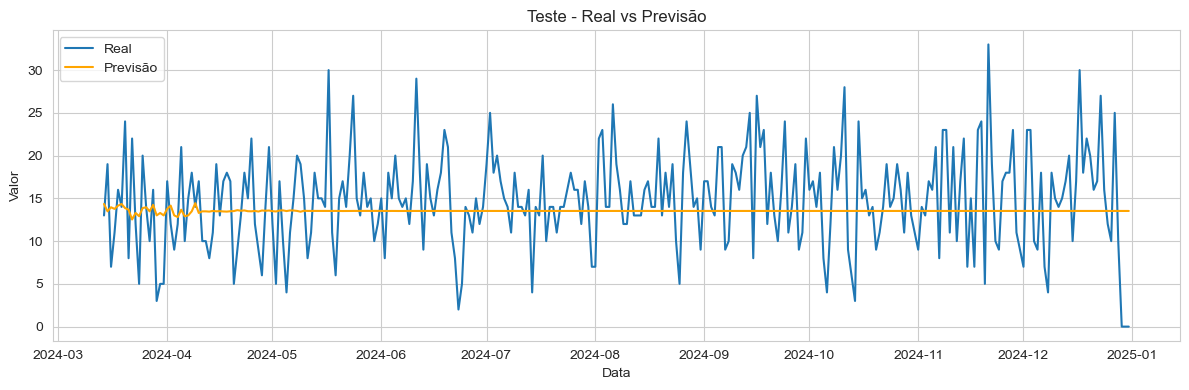

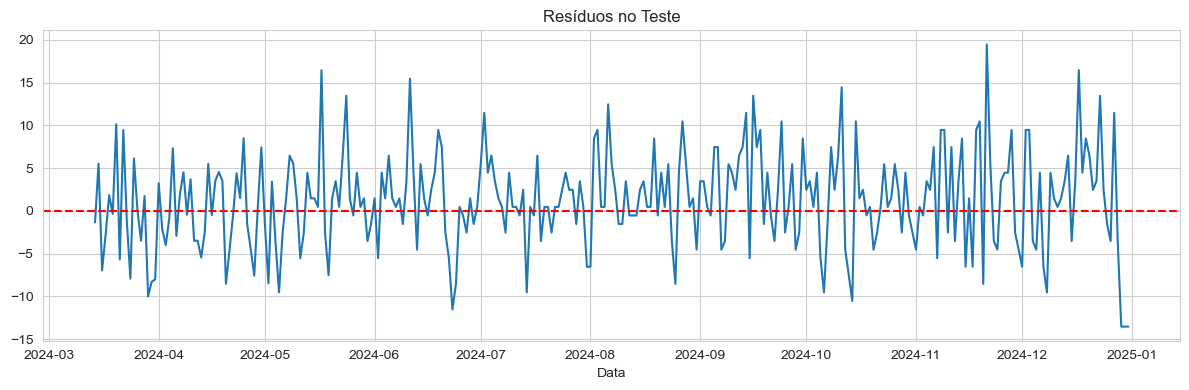

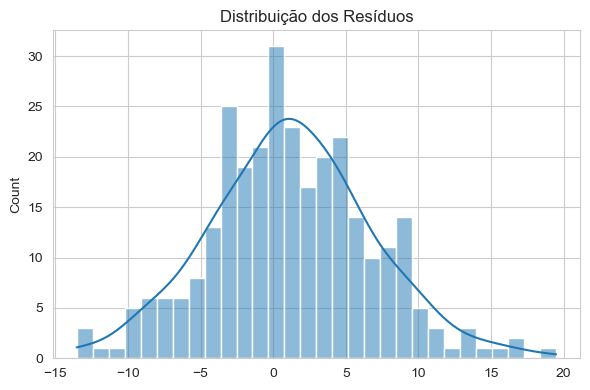

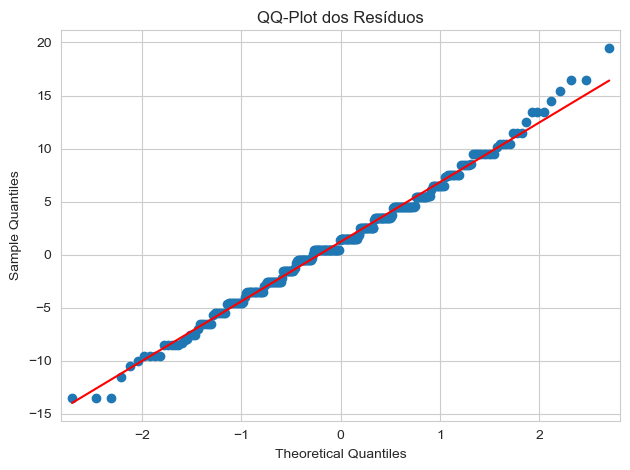

Melhor ordem SARIMA: (0, 1, 1) (1, 0, 0, 30)
AIC: -373.1463743524373
MAE Validação: 5.440920597966775
RMSE Validação: 6.788652518310835
MAPE Validação: 39.090511368253466
MAE Teste: 4.48046575267008
RMSE Teste: 5.745897675880966
MAPE Teste: 38.06879395699515


In [39]:
from src.modelo_sarima import modelar_sarima_automatico

y_train, y_val, y_test = dividir_modelagem(serie)

resultados = modelar_sarima_automatico(y_train, y_val, y_test, m=30)

print("Melhor ordem SARIMA:", resultados['melhor_ordem'], resultados['melhor_ordem_sazonal'])
print("AIC:", resultados['aic'])
print("MAE Validação:", resultados['mae_val'])
print("RMSE Validação:", resultados['rmse_val'])
print("MAPE Validação:", resultados['mape_val'])
print("MAE Teste:", resultados['mae_test'])
print("RMSE Teste:", resultados['rmse_test'])
print("MAPE Teste:", resultados['mape_test'])


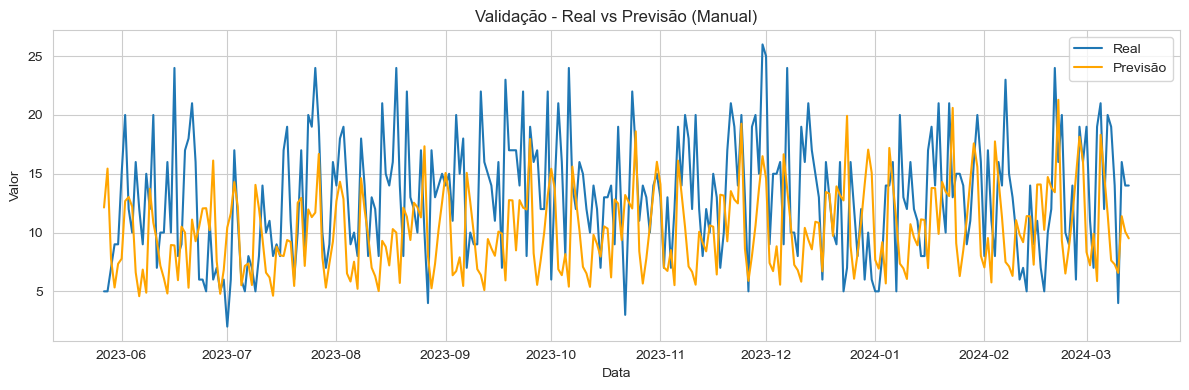

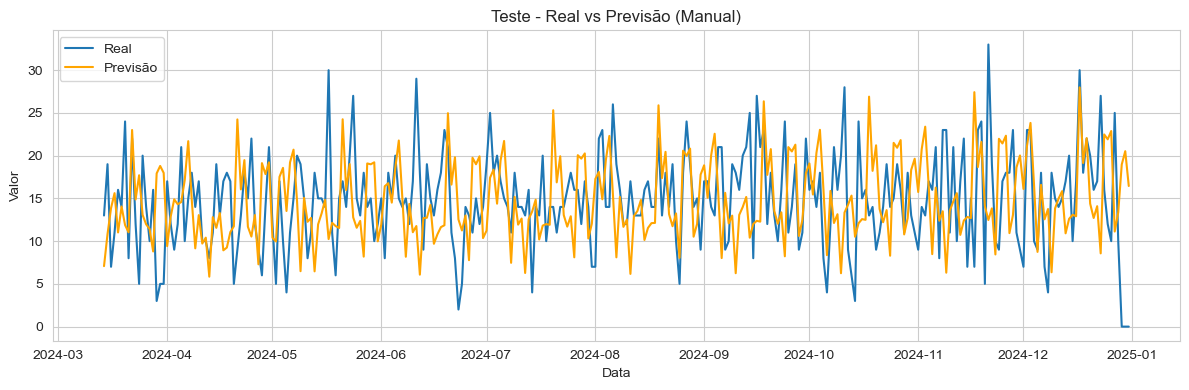

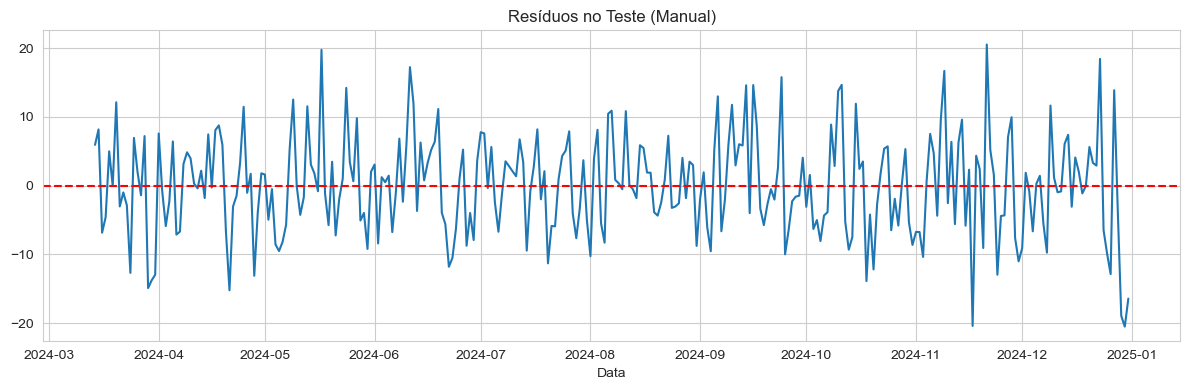

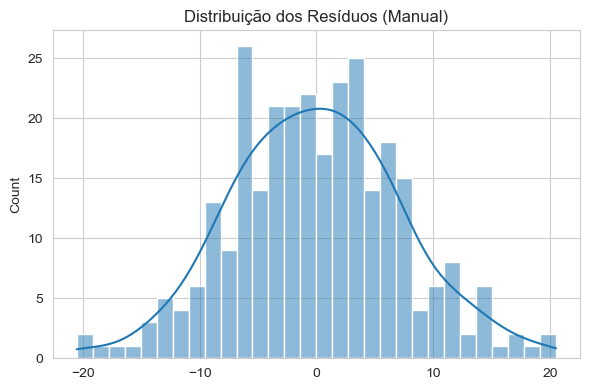

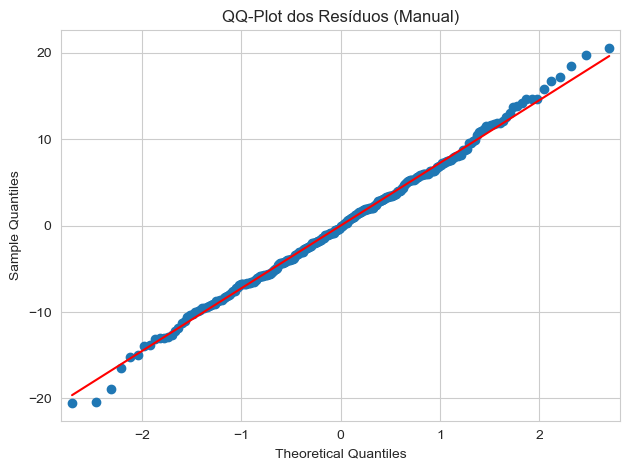

MAE Validação: 5.162462692324105
MAPE Validação: 43.35298118867465
RMSE Validação: 6.43565843200539
MAE Teste: 5.77793082088521
MAPE Teste: 48.743479703412795
RMSE Teste: 7.248472090762961


In [ ]:
from src.modelo_sarima import modelar_sarima_manual


resultado_manual = modelar_sarima_manual(
    y_train,
    y_val,
    y_test,
    order=(2, 1, 2),             
    seasonal_order=(1, 2, 1, 30)  
)

print("MAE Validação:", resultado_manual['mae_val'])
print("MAPE Validação:", resultado_manual['mape_val'])
print("RMSE Validação:", resultado_manual['rmse_val'])

print("MAE Teste:", resultado_manual['mae_test'])
print("MAPE Teste:", resultado_manual['mape_test'])
print("RMSE Teste:", resultado_manual['rmse_test'])


MAE: 2.08
RMSE: 2.68
MAPE: 61.08%


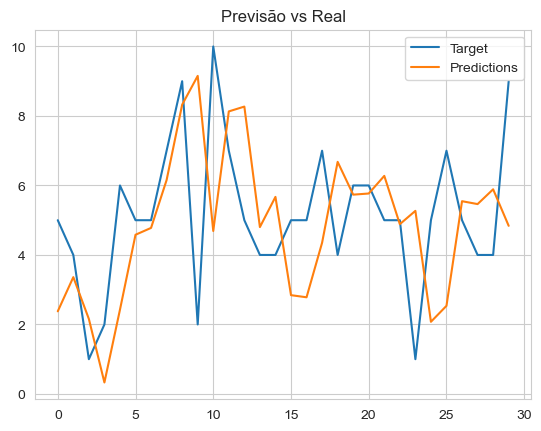

In [61]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Previsão passo a passo ---
predictions = []
startpoint = 70

# Primeira previsão
modelo_arma = ARIMA(serie[:startpoint], order=(4, 2, 0)).fit()
predictions.append(modelo_arma.forecast())

# Demais previsões
for i in range(29):
    startpoint += 1
    modelo_arma = ARIMA(serie[:startpoint], order=(4, 2, 0)).fit()
    predictions.append(modelo_arma.forecast())

# Corrigir estrutura das previsões
predictions = [float(p[0]) for p in predictions]

# Valores reais
target = serie[70:100].values 

# --- Cálculo das métricas ---
mae = mean_absolute_error(target, predictions)
rmse = np.sqrt(mean_squared_error(target, predictions))
mape = np.mean(np.abs((target - predictions) / target)) * 100

# Mostrar métricas
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# --- Plot ---
plt.plot(range(30), target, label='Target')
plt.plot(range(30), predictions, label='Predictions')
plt.legend()
plt.title("Previsão vs Real")
plt.show()


# Autoregressivo

MAE: 4.1024
MSE: 27.8742
RMSE: 5.2796
SMAPE: 30.88%


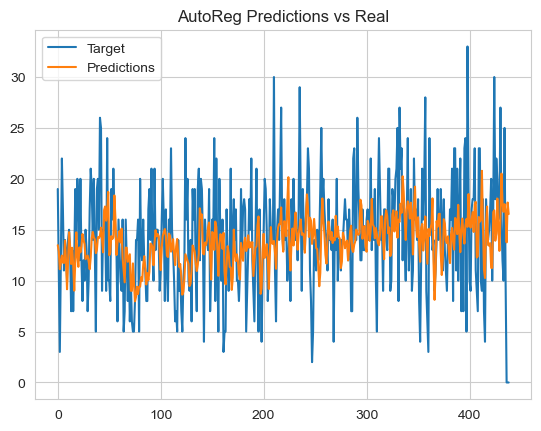

Previsão do próximo dia: 10.2621


In [75]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator = np.where(denominator == 0, 1e-10, denominator)  # evitar divisão por zero
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100


# Separar dados
trainSize = np.int32(np.floor(0.70 * len(serie)))
testSize = len(serie) - trainSize
x_treino = serie[:trainSize]
x_test = serie[trainSize:]

# Inicializar modelo com treino
xl = x_treino.tolist()
startpoint = len(x_treino)

armodel = AutoReg(x_treino, lags=20).fit()
predictions = []

# Primeira previsão
pred = armodel.model.predict(armodel.params, start=startpoint, end=startpoint)
predictions.append(pred[0])  # extrair valor do array
startpoint += 1

# Previsões passo a passo
for i in range(len(x_test) - 1):
    xl.append(x_test[i])  # atualiza com valor real
    armodel = AutoReg(xl, lags=20).fit()
    pred = armodel.model.predict(armodel.params, start=startpoint, end=startpoint)
    predictions.append(pred[0])
    startpoint += 1

# Transformar x_test em array para cálculo
target = x_test[:len(predictions)].values  # garantir mesmo tamanho

# --- Cálculo das métricas ---
mae = mean_absolute_error(target, predictions)
mse = mean_squared_error(target, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((target - predictions) / (target + 1e-10))) * 100  # evitar divisão por zero

# --- Resultados ---
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

smape_value = smape(target, predictions)
print(f"SMAPE: {smape_value:.2f}%")

# --- Plot ---
plt.plot(range(len(target)), target, label='Target')
plt.plot(range(len(predictions)), predictions, label='Predictions')
plt.legend()
plt.title("AutoReg Predictions vs Real")
plt.show()

# Define o número de lags (ajuste conforme seu modelo anterior)
lags = 20

# Treina o modelo com toda a série
modelo_final = AutoReg(serie, lags=lags).fit()

# Faz a previsão do próximo ponto
proxima_previsao = modelo_final.predict(start=len(serie), end=len(serie))

# Mostra o resultado
print(f"Previsão do próximo dia: {proxima_previsao[0]:.4f}")

In [70]:
from tqdm import tqdm

melhor_lag = 1
melhor_mae = np.inf

for lag in tqdm(range(5, 61, 5)):
    try:
        armodel = AutoReg(x_treino, lags=lag).fit()
        preds = armodel.predict(start=len(x_treino), end=len(serie)-1, dynamic=False)
        mae = mean_absolute_error(x_test[:len(preds)], preds)
        if mae < melhor_mae:
            melhor_mae = mae
            melhor_lag = lag
    except Exception as e:
        continue

print(f"Melhor lag: {melhor_lag} com MAE = {melhor_mae:.4f}")


100%|██████████| 12/12 [00:00<00:00, 19.81it/s]

Melhor lag: 45 com MAE = 4.3439


# SVR - multi step ahead

Tamanho do dataset original: 1461
Tamanho do datasetShifted (antes de dropar NaNs): (1461, 18)
          0         1         2         3         4         5         6   \
0   0.060606       NaN       NaN       NaN       NaN       NaN       NaN   
1   0.060606  0.060606       NaN       NaN       NaN       NaN       NaN   
2   0.151515  0.060606  0.060606       NaN       NaN       NaN       NaN   
3   0.151515  0.151515  0.060606  0.060606       NaN       NaN       NaN   
4   0.212121  0.151515  0.151515  0.060606  0.060606       NaN       NaN   
5   0.181818  0.212121  0.151515  0.151515  0.060606  0.060606       NaN   
6   0.242424  0.181818  0.212121  0.151515  0.151515  0.060606  0.060606   
7   0.090909  0.242424  0.181818  0.212121  0.151515  0.151515  0.060606   
8   0.212121  0.090909  0.242424  0.181818  0.212121  0.151515  0.151515   
9   0.090909  0.212121  0.090909  0.242424  0.181818  0.212121  0.151515   
10  0.212121  0.090909  0.212121  0.090909  0.242424  0.181818  0.212

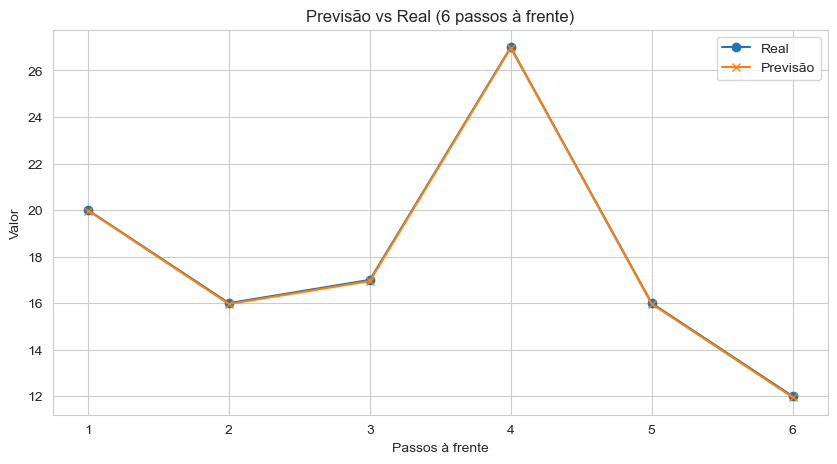

In [184]:
import numpy as np
import pandas as pd
import warnings
from sklearn.svm import SVR  # support vector regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

serie_data = serie_data.fillna(0)

# --- validação inicial da série ---
if np.isnan(serie_data.values).any():
    raise ValueError("A série original contém valores NaN. Limpe os dados antes de rodar o modelo.")

# parâmetros
trainSplit = 0.6
validSplit = 0.2

dataset = serie_data.values
print(f"Tamanho do dataset original: {len(dataset)}")

trainSize = int(np.floor(trainSplit * len(dataset)))
validSize = int(np.floor(validSplit * len(dataset)))

maxData = np.max(dataset)
minData = np.min(dataset)

ndataset = (dataset - minData) / (maxData - minData)
datasetSeries = pd.Series(ndataset)

dimension = 6
stepahead = 6         # <-- aqui você define quantos passos quer prever
stepahead_max = 12    # <-- fixo para manter coerência nas previsões

# Criação do dataset deslocado com base em stepahead_max
datasetShifted = pd.concat([datasetSeries.shift(i) for i in range(dimension + stepahead_max)], axis=1)
print(f"Tamanho do datasetShifted (antes de dropar NaNs): {datasetShifted.shape}")
print(datasetShifted.head(25))

# Entrada (lags)
Input = datasetShifted.iloc[dimension + (stepahead_max - 1):, -dimension:]
print(f"Tamanho do Input (após slice): {Input.shape}")

# listas para armazenar
previsoes = []
reais = []

for i in range(stepahead):
    # Target deslocado i passos à frente (baseado em stepahead_max)
    Target = datasetShifted.iloc[dimension + (stepahead_max - 1):, -(dimension + i + 1)]

    # concatena Input + Target e remove NaNs apenas nessa fatia
    df_temp = pd.concat([Input, Target], axis=1).dropna()
    if df_temp.empty:
        raise ValueError(f"Após remover NaNs, não restaram dados suficientes para o passo {i+1}.")

    X = df_temp.iloc[:, :-1]
    y = df_temp.iloc[:, -1]

    mySVR = SVR(C=1000.0, epsilon=0.001, gamma=3.2)
    mySVR.fit(X, y)

    # prevê usando a última linha **original** de Input
    last_instance = Input.iloc[-1, :].values.reshape(1, -1)
    previsao_norm = mySVR.predict(last_instance)[0]

    # dessinaliza
    previsao_real = previsao_norm * (maxData - minData) + minData
    valor_real = y.iloc[-1] * (maxData - minData) + minData

    print(f"Previsão passo {i+1}: {int(round(previsao_real))}")

    previsoes.append(previsao_real)
    reais.append(valor_real)

# métricas
mae = mean_absolute_error(reais, previsoes)
mse_ = mean_squared_error(reais, previsoes)
rmse = np.sqrt(mse_)

def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = safe_mape(reais, previsoes)

print(f"\nErros do modelo:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse_:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# gráfico
plt.figure(figsize=(10, 5))
x = np.arange(1, stepahead + 1)
plt.plot(x, reais, label='Real', marker='o')
plt.plot(x, previsoes, label='Previsão', marker='x')
plt.title(f"Previsão vs Real ({stepahead} passos à frente)")
plt.xlabel("Passos à frente")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()


In [181]:
print(f"Passo {i+1} - Valores alvo:\n{y.describe()}")


Passo 6 - Valores alvo:
count    1444.000000
mean        0.299253
std         0.162332
min         0.000000
25%         0.181818
50%         0.272727
75%         0.393939
max         1.000000
Name: 6, dtype: float64


In [182]:
print(f"Previsão passo {i+1}: {previsao_real:.2f}")



Previsão passo 6: 11.96


# SARIMA COM R

RMSE: 5.22
MAE: 3.67
MAPE: 32.29%


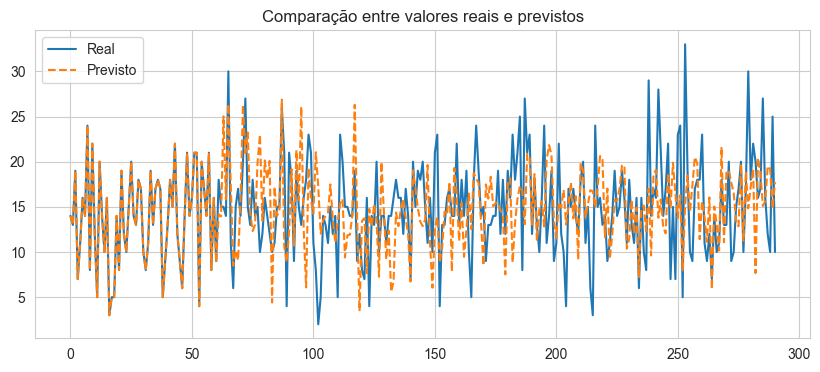

In [212]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources' 
os.environ["PYTHONMALLOC"] = "malloc"

import rpy2.robjects as r
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
import rpy2.robjects.numpy2ri

trainset = 0.60
valset = 0.20
dimension = 30

serie_data = serie_data.dropna()

sarima_train = serie_data[:int(np.floor(trainset * len(serie_data)))]
sarima_val = serie_data[int(np.floor(trainset * len(serie_data))):int(np.floor((trainset + valset) * len(serie_data)))]
sarima_test = serie_data[int(np.floor((trainset + valset) * len(serie_data))):]

# Importar forecast
#Funções da bibilioteca em R sendo armazenadas em variáveis
r.r('library(forecast)')
colnames=r.r('colnames')
arima = r.r('auto.arima')
arimaTest = r.r('Arima')
ordem = r.r('cbind')
fitted = r.r('fitted')
forecast = r.r('forecast')
arimaorder = r.r('arimaorder')
ts = r.r('ts')

# Converter os arrays numpy em FloatVector R
with localconverter(default_converter + rpy2.robjects.numpy2ri.converter):
    train_r = FloatVector(sarima_train)
    val_r = FloatVector(sarima_val)
    test_r = FloatVector(sarima_test)

# Criar objetos ts corretamente
sarima_train_r = ts(train_r, frequency=dimension)
sarima_val_r = ts(val_r, frequency=dimension)
sarima_test_r = ts(test_r, frequency=dimension)

# Treinar o modelo automático
# mdl_sarima = auto_arima(sarima_train_r)
# print(mdl_sarima)

# Treinar o modelo manual
order = r.IntVector([2, 1, 2])  # (p,d,q)
seasonal = r.ListVector({
    'order': r.IntVector([1, 2, 2]),  # (P,D,Q)
    'period': r.IntVector([dimension])
})

mdl_sarima = arimaTest(sarima_train_r, order=order, seasonal=seasonal)


# Previsões
fitTreinoSarima = arimaTest(sarima_train_r, model=mdl_sarima)
fitValidSarima = arimaTest(sarima_val_r, model=mdl_sarima)
fitTesteSarima = arimaTest(sarima_test_r, model=mdl_sarima)

# Fitted values
predSarimaTest = fitted(fitTesteSarima)

real = np.array(sarima_test)
previsto = np.array(predSarimaTest)

mask = ~np.isnan(real) & ~np.isnan(previsto)
real = real[mask]
previsto = previsto[mask]

rmse = np.sqrt(mean_squared_error(real, previsto))
mae = mean_absolute_error(real, previsto)
mape = np.mean(np.abs((real - previsto) / real)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')


# Plot
plt.figure(figsize=(10, 4))
plt.plot(range(len(real)), real, label='Real')
plt.plot(range(len(previsto)), previsto, label='Previsto', linestyle='--')
plt.legend()
plt.title('Comparação entre valores reais e previstos')
plt.show()


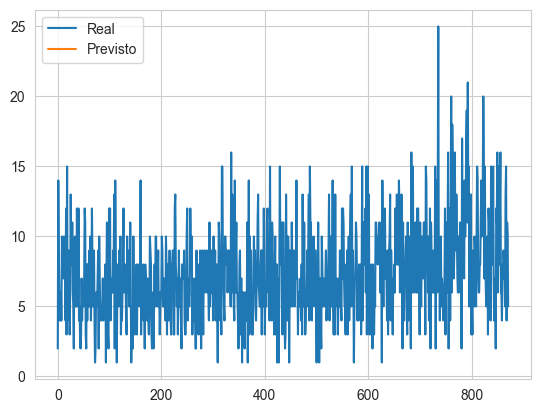

Time Series:
Start = c(30, 2) 
End = c(30, 2) 
Frequency = 30 
[1] 13.32648



In [214]:
forecast_ahead = forecast(mdl_sarima, h = 1)
preds_ahead= forecast_ahead[3]

plt.plot(range(0,len(sarima_train)),sarima_train)
plt.plot(range(len(sarima_train),len(sarima_train)+1),preds_ahead)
plt.legend(['Real','Previsto'])
plt.show()

print(preds_ahead)

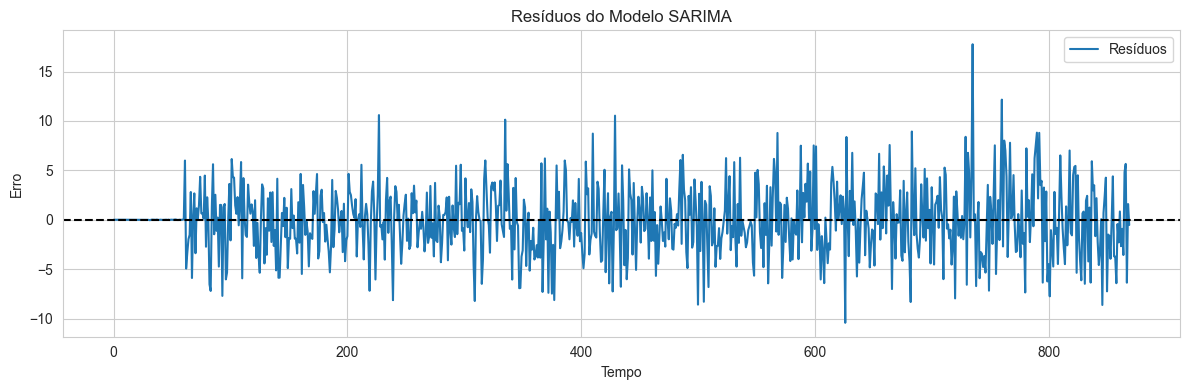

In [ ]:
# Obtém os resíduos do modelo ajustado
residuos = np.array(r.r('residuals')(mdl_sarima))

# Máscara para remover NaNs (se houver)
residuos = residuos[~np.isnan(residuos)]

# Plot dos resíduos
plt.figure(figsize=(12, 4))
plt.plot(residuos, label='Resíduos')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Resíduos do Modelo SARIMA')
plt.xlabel('Tempo')
plt.ylabel('Erro')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

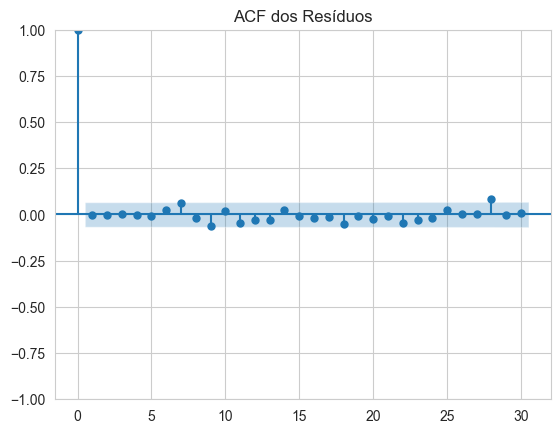

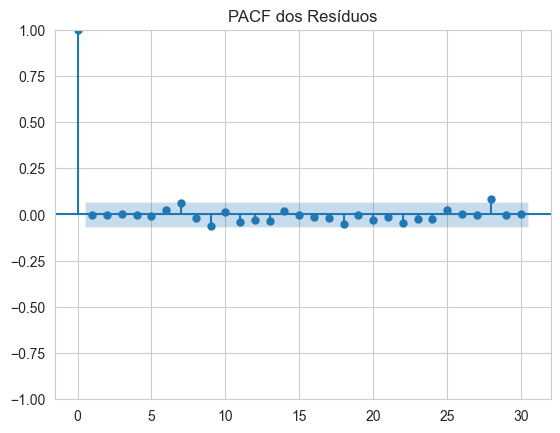

Shapiro-Wilk p-valor: 0.0000
ARCH Test p-valor: 0.0681


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuos, lags=30)
plt.title('ACF dos Resíduos')
plt.show()

plot_pacf(residuos, lags=30)
plt.title('PACF dos Resíduos')
plt.show()

from scipy.stats import shapiro

stat, p = shapiro(residuos)
print(f'Shapiro-Wilk p-valor: {p:.4f}')

from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(residuos)
print(f'ARCH Test p-valor: {arch_test[1]:.4f}')

